# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from REACTRL import RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from REACTRL import plot_graph, show_reset, show_done, show_step
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from matplotlib import pyplot as plt, patches

cpu


### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect


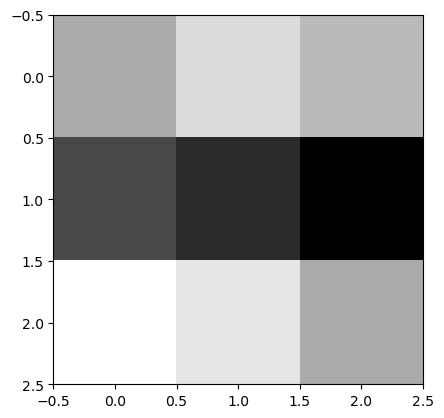

In [3]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
#template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
#plt.imshow(template)

template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

### Set the parameters and create a RealExpEnv object

In [4]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = 'C:/Users/wun2/github/reaction_rl/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2460.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128
im_size_nm = 5 #Image size in nm 
scan_mV = 500 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect
Load cnn weight


# Bug test  image size when operating tip_form function, the image size changes

In [5]:
# initial scan_image

env.createc_controller.scan_image()


The scan will take 49.8 seconds
offset_test0000 [-50.84006882  86.99994049]
offset_test1111 [-50.84006882  86.99994049]
offset_test2222 [-50.84006882  86.99994049]


(array([[-2.01714039, -2.01696873, -2.01708841, ..., -2.02151728,
         -2.02146792, -2.02165771],
        [-2.02180839, -2.02207851, -2.02216959, ..., -2.02135611,
         -2.02143407, -2.02120018],
        [-2.0213275 , -2.02120543, -2.02127552, ..., -2.02428007,
         -2.02426982, -2.02433729],
        ...,
        [-2.02020478, -2.02010083, -2.02011633, ..., -2.02194095,
         -2.0220058 , -2.02209949],
        [-2.02213073, -2.02222681, -2.02220082, ..., -2.02358365,
         -2.02343535, -2.02330303],
        [-2.02324319, -2.02307653, -2.02307415, ..., -2.02321959,
         -2.02339125, -2.0235889 ]]),
 array([[-2.02011895, -2.02010083, -2.02044892, ..., -2.01993179,
         -2.02000189, -2.01992655],
        [-2.02000189, -2.02010846, -2.02038145, ..., -2.02390313,
         -2.02391624, -2.02399158],
        [-2.02402282, -2.02391624, -2.02373695, ..., -2.02405667,
         -2.02395511, -2.02376795],
        ...,
        [-2.02273369, -2.02253866, -2.02229953, ..., -

# Basic parameters

In [34]:
basic_params=['Delta X[Dac]', 'Delta Y[Dac]', 'Num.X', 'Num.Y', 'Delay X+', 'Delay X-', 'Delay Y', 'DX/DDeltaX','GainX','GainY','GainZ', 'Rotation', 'BiasVolt.[mV]', 'GainPre 10^', 'ScanChannels', 'PlanDx', 'PlanDy', 'OffsetX', 'OffsetY', 'ZPiezoconst', 'XPiezoconst', 'YPiezoconst', 'RepeatRotinc', 'RptBVoltinc', 'Repeatinterval', 'Repeatcounter', 'RepeatXoffset', 'RepeatYoffset', 'Scantype', 'ScanXMode', 'Scancoarse', 'CHMode', 'Channels', 'Preamptype', 'VFBMode', 'RotCMode', 'ScanYMode', 'ScanYDirec']

In [35]:
for i in basic_params:
    print(env.createc_controller.stm.getparam(i))



128
128
1
1
1
19
10
10
3
0.00
500.00
9
2
0.1250
0.0120
77392.6
-132438.0
  8.63
 34.44
 34.44
0
0
0
0
0
0
1
2
0
0
4
1
0
1
1
1


In [25]:
print(env.createc_controller.stm.getparam('Length x[A]'))
print(env.createc_controller.stm.getparam('Length y[A]'))
print(env.createc_controller.im_size_nm)
print(env.createc_controller.stm.getparam("GainX"))
print(env.createc_controller.stm.getparam("GainY"))
print(env.createc_controller.stm.getparam("GainZ"))

49.6099
49.6099
5
10
10
3


In [31]:
env.createc_controller.stm.getp

com_error: (-2147352562, 'Invalid number of parameters.', None, None)

# parameters change after tip_form

In [26]:
# env.createc_controller.ramp_bias_mV(-1.2)
env.createc_controller.tip_form(2, 40, 40)

In [14]:
env.createc_controller.set_Z_approach(2)        
env.createc_controller.stm.btn_tipform(10, 10)

In [20]:
print(env.createc_controller.stm.getparam('Length x[A]'))
print(env.createc_controller.stm.getparam('Length y[A]'))
print(env.createc_controller.im_size_nm)
print(env.createc_controller.stm.getparam("GainX"))
print(env.createc_controller.stm.getparam("GainY"))
print(env.createc_controller.stm.getparam("GainZ"))

49.6099
49.6099
5
10
10
3


In [18]:
env.createc_controller.pixel

128

In [16]:
env.createc_controller.scan_image()   # problem: long scanning time, even never terminate

The scan will take 12.5 seconds
offset_test0000 [-50.84006882  86.99994049]
offset_test1111 [-50.84006882  86.99994049]


KeyboardInterrupt: 

# change parameters

In [21]:
env.createc_controller.stm.setparam('GainX',10)
GainX = float(env.createc_controller.stm.getparam("GainX"))
env.createc_controller.stm.setparam('GainY',10)
GainY = float(env.createc_controller.stm.getparam("GainY"))
env.createc_controller.stm.setparam('GainZ',3)
GainZ = float(env.createc_controller.stm.getparam("GainZ"))
env.createc_controller.im_size_nm=5
# env.createc_controller.stm.setparam('Delta X [Dac]',59)
env.createc_controller.get_Delta_X(5)

59

In [22]:
env.createc_controller.scan_image() # problem: long scanning time, even never terminate, although change the paramters as this way

The scan will take 12.5 seconds
offset_test0000 [-50.84006882  86.99994049]
offset_test1111 [-50.84006882  86.99994049]


KeyboardInterrupt: 

#  check what happens

In [30]:
env.createc_controller.stm.scanstart()
env.createc_controller.stm.scanstatus  # always keep the scanstatus as 2 i.e. running state


2

In [34]:

env.createc_controller.stm.scanstart() #Starts a new STM scan. Similar to pressing the button Scanstart
print('aaaa')
while True:

    scanstatus = env.createc_controller.stm.scanstatus
    print('bbb')
    if scanstatus!=2:
        break


# Test spiral trajectory

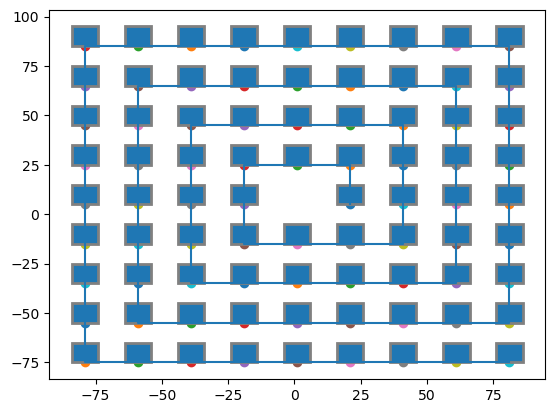

In [8]:

env.computeLocationIDs()
points=env.computeLocationIDs()
all_x=np.array([i[0] for i in points])
all_y=np.array([i[1] for i in points])
ref_x=1
ref_y=5
cellsize=10
for point in range(len(points)):
    i=points[point][0]
    j=points[point][1]
    plt.scatter(ref_x+i*cellsize,ref_y+j*cellsize)
    plt.gca().add_patch(patches.Rectangle((ref_x+i*cellsize-5,  ref_y+j*cellsize), 10, 10, fill=True, edgecolor='grey', lw=2))
    
    
plt.plot(ref_x+all_x*cellsize,ref_y+all_y*cellsize)


starting new approach area...
-4 0 80.0 40 40.0 80.0
-3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
-3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 -4 66.05551275463989 40 40.0 80.0
0 4 66.05551275463989 40 40.0 80.0
2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
4 0 66.05551275463989 40 40.0 80.0
-30 -20 35
starting new approach area...
-4 0 80.0 40 40.0 80.0
-3 -2 66.05551275463989 30 36.05551275463989 66.05551275463989
-3 2 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 -3 66.05551275463989 30 36.05551275463989 66.05551275463989
-2 3 66.05551275463989 30 36.05551275463989 66.05551275463989
0 -4 66.05551275463989 40 40.0 

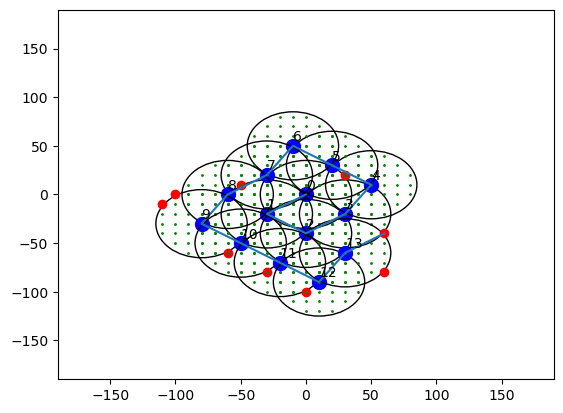

In [9]:
new_x_a=0
new_y_a=0
radius=35
check_similarity=[]
check_similarity.append([new_x_a, new_y_a])
upper_limit_move=400

found=False
epoch=0

while not found:
    plt.text(new_x_a, new_y_a+5, epoch)
#     env.switch_approach_area()
#     env.ForbiddenArea(forbiden_radius=radius)
    plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False))
    new_x_a, new_y_a=env.GetNextGoodClosest(new_x_a, new_y_a, initial_x=0, initial_y=0, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
    print(new_x_a, new_y_a, radius)
    
    if  new_x_a==None:
        
        new_x_a, new_y_a=check_similarity[-1][0], check_similarity[-1][1]
        plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False, color='yellow'))
        radius=radius*2
        env.max_radius=300
        upper_limit_move=upper_limit_move+20000
#         plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False, color='yellow'))    
    else:
        radius=35
        env.max_radius=150
        upper_limit_move=400
#         plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False))
    
    if radius>1000:
        break
        
    check_similarity.append([new_x_a, new_y_a])
        
#     plt.gca().add_patch(patches.Circle((new_x_a, new_y_a), radius, fill=False))
    if new_x_a>50:
        found=True
    epoch=epoch+1
        
plt.plot([i[0] for i in check_similarity], [i[1] for i in check_similarity])
plt.xlim(-190, 190)
plt.ylim(-190, 190)
plt.savefig('path.png')

C:\Users\wun2\AppData\Local\Temp\ipykernel_1868\446068200.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros((2*num_points+1,2*num_points+1), dtype=np.bool)


The scan will take 12.5 seconds
offset_test0000 [2 0]
offset_test1111 [2 0]
offset_test2222 [2 0]
The scan will take 12.5 seconds
offset_test0000 [2 2]
offset_test1111 [2 2]
offset_test2222 [2 2]
The scan will take 12.5 seconds
offset_test0000 [0 2]
offset_test1111 [0 2]
offset_test2222 [0 2]
The scan will take 12.5 seconds
offset_test0000 [-2  2]
offset_test1111 [-2  2]
offset_test2222 [-2  2]
The scan will take 12.5 seconds
offset_test0000 [-2  0]
offset_test1111 [-2  0]
offset_test2222 [-2  0]
The scan will take 12.5 seconds
offset_test0000 [-2 -2]
offset_test1111 [-2 -2]
offset_test2222 [-2 -2]
The scan will take 12.5 seconds
offset_test0000 [ 0 -2]
offset_test1111 [ 0 -2]
offset_test2222 [ 0 -2]
The scan will take 12.5 seconds
offset_test0000 [ 2 -2]
offset_test1111 [ 2 -2]
offset_test2222 [ 2 -2]
The scan will take 12.5 seconds
offset_test0000 [ 4 -2]
offset_test1111 [ 4 -2]
offset_test2222 [ 4 -2]
The scan will take 12.5 seconds
offset_test0000 [4 0]
offset_test1111 [4 0]
offset

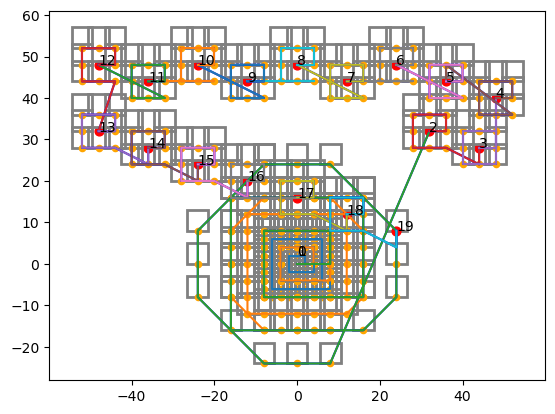

In [93]:
new_x_a=0
new_y_a=0
radius=1
euclid_limit=12
leg=0
check_similarity=[]
for epoch in range(20):
    check_similarity.append([new_x_a, new_y_a])
    new_x_a, new_y_a=select_point(ref_x=new_x_a, ref_y=new_y_a, epoch=epoch, check_similarity=check_similarity, leg=leg, radius=radius, euclid_limit=euclid_limit, approach_limit=[-50, 50, -50, 50])
    if [new_x_a, new_y_a]==check_similarity[-1]:
        radius=radius*2
        euclid_limit=euclid_limit+8
    else:
        radius=2
        euclid_limit=8

    if radius>24:
        break
    


In [19]:
atom_forward = blob_detection(info[img_forward])[0]
atom_backward = blob_detection(info[img_backward])[0]

max_num_dect = 10
done_dect_atom = False
for i_dect in range(max_num_dect):

    if len(atom_forward)>0 and len(atom_backward)>0:
        done_dect_atom = True
        continue
    else:
        # looking for new area
        # TODO spiral path planing to choose tip position
        ID= compositionID()
        x=np.array([abc[i][0] for i in range(len(ID))])
        y=np.array([abc[i][1] for i in range(len(ID))])
        x=x-x.min()
        y=y-y.min()
        for i in range(len(ID)):
            
        forbiden_area = 
        tip_x_new, tip_y_new = New_tippos(tip_x, tip_y, forbiden:area) 
        
# TODO if not done_dect_atom after max_num_dect times looking for

80

In [77]:
def scan_trajectory(abc, initial_offset_nm=np.array([-50, 90])):
    images=[]
    for i in range(0,len(abc)):
        env.createc_controller.offset_nm=np.array([initial_offset_nm[0]+80/16*abc[i][0],initial_offset_nm[0]+80/16*abc[i][1]])
        env.createc_controller.im_size_nm = 5
        image=env.createc_controller.scan_image()
        env.createc_controller.stm.quicksave()
        # images.append(image)
        # plt.imshow(image[0])
        # plt.show()
        # print(image)
        print(env.createc_controller.get_offset_nm()[0],env.createc_controller.get_offset_nm()[1])
        # plt.scatter(env.createc_controller.get_offset_nm()[0],env.createc_controller.get_offset_nm()[1])
        plt.scatter(env.createc_controller.offset_nm[0],env.createc_controller.offset_nm[1])
        # plt.plot(env.createc_controller.offset_nm[0],env.createc_controller.offset_nm[1])

        
        plt.gca().add_patch(patches.Rectangle((initial_offset_nm[0]+80/16*abc[i][0]-2.5, initial_offset_nm[1]+80/16*abc[i][1]), 5, 5, fill=False, edgecolor='grey', lw=2))
        # offset_nm=env.createc_controller.offset_nm+5
    plt.plot([initial_offset_nm[0]+80/16*i[0] for i in abc], [initial_offset_nm[1]+80/16*i[1] for i in abc])

In [ ]:
createc_controller.stm.setparam('Delta X [DAC]', 118)
createc_controller.stm.setparam('BiasVolt.[mV]', 50)
createc_controller.stm.setparam('ZPiezoconst', 8.43)
createc_controller.stm.setparam('SetPoint', 5.00E-12)
createc_controller.stm.setparam('FBLogIset', 50)
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)
env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)
env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



### Create a sac_agent object

In [10]:
#TODO
batch_size= 64 #Set minibatch size
LEARNING_RATE = 0.0003 #Set learning rate

#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1,1,1]), low = torch.tensor([-1,-1,-1,-1,1/3,1/2]))

#Initialize the soft actor-critic agent
alpha = 1.0
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=alpha)

### Create a HerReplayMemory object
Here we use the hindsight experience replay with the 'future' strategy to sample goals

In [11]:
#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env, strategy = 'future')

In [6]:
memory.n_sampled_goal

2

### Create a Episode_Memory object
The episode memory class is used to store all the relavant information in each training episode, including the STM images, state, action, reward, etc.

In [12]:
episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
folder_name =  'C:/Users/wun2/github/Atom_manipulation_with_RL/test_nian'

### Set the hyperparameters for Emphasize Recent Experience replay

In [13]:
c_k_min = 500
eta = 0.994
max_ep_len = max_len

### Create empty lists for logging performances

In [14]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

In [15]:
max_steps = 5
num_episodes = 50
episode_start = 0

In [ ]:
done_dect_atom=False


In [ ]:
# find a section to condition tip
start_crash_hole=0
approach_z=2

def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length

env.default_max_radius_cellsize(cellsize=20, max_radius=200)
points=env.computeLocationIDs()
cond_area_center_x, cond_area_center_y, cond_area_length=tip_cond_area()

env.createc_controller.ramp_bias_mV(-1.2)
env.createc_controller.tip_form(approach_z, cond_area_center_x+points[start_crash_hole][0]*cellsize,cond_area_center_y+points[start_crash_hole][1]*cellsize)
print(env.createc_controller.im_size_nm)
start_crash_hole=start_crash_hole

In [ ]:
start_x = 0
start_y = 0
tip_x = 0
tip_y = 0
check_similarity=None
check_similarity.append([tip_x, tip_y])
radius = 35
upper_limit_move=400
env.max_radius=150

image_forward = info['img_info']['img_forward']
image_backward =info['img_info']['img_backward']


# dectect atoms
isAtom = False



# debris
debris_thres = 6
DebresCounter = 0
noDebris = False



# Crash dectected
crash_thres = 1e-25 
approach_z = 4
noCrash = False


while not isAtom or not noDebris or not noCrash:
    
    # detect atoms
    atom_forward = blob_detection(info[img_forward])[0]

    if len(atom_forward)>0:
        isAtom = True

    # detect debris
    noDebris =  ((np.max(image_forward) - np.min(image_forward)) < debris_thres) 
    
    # dectect crash
    noCrash = (np.max(img_forward)-np.min(img_forward) )< crash_thres and (np.mean(img_forward)>0)
    
    if isAtom and noDebris and noCrash:
        continue
        
        
        
    else:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        if tip_x==None:
            tip_x, tip_y=check_similarity[-1][0], check_similarity[-1][1]
            image=env.set_newtip_pos(tip_x, tip_y)
            image_forward, image_backward =image[0], image[1]
            radius=radius*2
            env.max_radius=env.max_radius*2
            upper_limit_move=upper_limit_move+20000
        else:
            radius=35
            upper_limit_move=400
            env.max_radius=150
                
    
            
            
    check_similarity.append([tip_x, tip_y])        
    if radius>280:
        print('there is no section satisfying the demand within radius of 280 nm')
        break

    

        
        
    
    



In [ ]:
# dectect atoms
tip_x=0
tip_y=0
radius=35
max_num_dect = 10
check_similarity=[]
check_similarity.append([tip_x, tip_y])
upper_limit_move=400
done_dect_atom = False
for i_dect in range(max_num_dect):
    atom_forward = blob_detection(info[img_forward])[0]
    atom_backward = blob_detection(info[img_backward])[0]
    if len(atom_forward)>0 and len(atom_backward)>0:
        done_dect_atom = True
        continue
        plt.text(new_x_a, new_y_a+5, epoch)
    #     env.switch_approach_area()
    #     env.ForbiddenArea(forbiden_radius=radius)
        plt.gca().add_patch(patches.Circle((tip_x, tip_y), radius, fill=False))
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=0, initial_y=0, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        print(tip_x, tip_y, radius)  

        env.createc_controller.offset_nm=np.array([tip_x, tip_y])
        env.createc_controller.im_size_nm = 5
        image=env.createc_controller.scan_image()
        env.createc_controller.stm.quicksave()
        atom_forward, atom_backward =image[0], image[1]
        
        
            
        if len(atom_forward)>0 and len(atom_backward)>0:
            done_dect_atom = True
            
        else:
            tip_x, tip_y=check_similarity[-1][0], check_similarity[-1][1]
#             plt.gca().add_patch(patches.Circle((tip_x, tip_y), radius, fill=False, color='yellow'))
            radius=radius*2
            env.max_radius=300
            upper_limit_move=upper_limit_move+20000
            check_similarity.append([tip_x, tip_y])


        
# TODO if not done_dect_atom after max_num_dect times looking for

# debris
#  threshold for the difference between max and min values in the image. If this is exceeded, the region is considered to contain excessive roughness.
start_x = 0
start_y = 0
tip_x = 0
tip_y = 0
debris_thres = 6
DebresCounter = 0
noDebris = False
image_forward = info['img_info']['img_forward']
radius = 10
check_similarity=None

while not noDebris:
      noDebris =  ((np.max(image_forward) - np.min(image_forward)) < debris_thres)      
      if not noDebris:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        image=env.set_newtip_pos(tip_x, tip_y)
        image_forward, image_backward =image[0], image[1]
        radius=radius*2
        env.max_radius=300
        upper_limit_move=upper_limit_move+20000
        check_similarity.append([tip_x, tip_y])
        
        
# Crash dectected
crash_thres = 1e-25 
noCrash = False
approach_z = 4
while not noCrash:
    noCrash = (np.max(img_forward)-np.min(img_forward) )< crash_thres and (np.mean(img_forward)>0)
    
    if not noCrash:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        tip_z = env.createc_controller.set_Z_approach(approach_z)
        image=env.set_newtip_pos(tip_x, tip_y)
        image_forward, image_backward =image[0], image[1]
        radius=radius*2
        env.max_radius=300
        upper_limit_move=upper_limit_move+20000
        check_similarity.append([tip_x, tip_y])

# detect atoms or not

In [ ]:
tip_x=0
tip_y=0
radius=35
max_num_dect = 10
check_similarity=[]
check_similarity.append([tip_x, tip_y])
upper_limit_move=400
done_dect_atom = False
for i_dect in range(max_num_dect):
    atom_forward = blob_detection(info[img_forward])[0]
    atom_backward = blob_detection(info[img_backward])[0]
    if len(atom_forward)>0 and len(atom_backward)>0:
        done_dect_atom = True
        continue
        plt.text(new_x_a, new_y_a+5, epoch)
    #     env.switch_approach_area()
    #     env.ForbiddenArea(forbiden_radius=radius)
        plt.gca().add_patch(patches.Circle((tip_x, tip_y), radius, fill=False))
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=0, initial_y=0, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        print(tip_x, tip_y, radius)  

        env.createc_controller.offset_nm=np.array([tip_x, tip_y])
        env.createc_controller.im_size_nm = 5
        image=env.createc_controller.scan_image()
        env.createc_controller.stm.quicksave()
        atom_forward, atom_backward =image[0], image[1]
        
        
            
        if len(atom_forward)>0 and len(atom_backward)>0:
            done_dect_atom = True
            
        else:
            tip_x, tip_y=check_similarity[-1][0], check_similarity[-1][1]
#             plt.gca().add_patch(patches.Circle((tip_x, tip_y), radius, fill=False, color='yellow'))
            radius=radius*2
            env.max_radius=300
            upper_limit_move=upper_limit_move+20000
            check_similarity.append([tip_x, tip_y])


        
# TODO if not done_dect_atom after max_num_dect times looking for

# detect atoms or not

In [ ]:
def New_tippos(tip_x, tip_y, im_size_nm=5):
    env.createc_controller.offset_nm=np.array([tip_x, tip_y])
    env.createc_controller.im_size_nm = im_size_nm
    image=env.createc_controller.scan_image()
    env.createc_controller.stm.quicksave()
    return createc_controller.set_xy_nm(np.array([tip_x, tip_y]))

In [ ]:
atom_forward = blob_detection(info[img_forward])[0]
atom_backward = blob_detection(info[img_backward])[0]

max_num_dect = 10
done_dect_atom = False
for i_dect in range(max_num_dect):

    if len(atom_forward)>0 and len(atom_backward)>0:
        done_dect_atom = True
        continue
    else:
        # looking for new area
        # TODO spiral path planing to choose tip position
        ID= compositionID(tip_x, tip_y)
        forbiden_area = 
        tip_x_new, tip_y_new = New_tippos(tip_x, tip_y, forbiden:area) 
        
# TODO if not done_dect_atom after max_num_dect times looking for
    
    

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def FindEmptySquareArea(mat : np.array, ZERO=0) -> tuple:
    """_summary_

    Args:
        mat (np.array): pixel matrix
        ZERO (int, optional): _description_. Defaults to 0.

    Returns:
        length: the length of the square
        start_x: the x position of the start of the square
        start_y: the y position of the start of the square
    """    
    #Find the largest square of ZERO's in the matrix `mat`.
    #Source: https://stackoverflow.com/a/1726667
    
    # Extract array shape
    nrows, ncols = mat.shape
    
    # Check for null array / empty matrix or rows
    if not (nrows and ncols):
        return 0
    
    # Initiate null array based on row and column sizes
    counts = np.zeros((nrows, ncols))
    
    # For each row
    for i in reversed(range(nrows)):
        # The matrix must be rectangular (actually square)
        assert len(mat[i]) == ncols
        
        # For each element in the row
        for j in reversed(range(ncols)):
            
            # If the element is zero, check around it
            if mat[i][j] == ZERO:
                counts[i][j] = (1 + min(
                    counts[i][j+1],   # east
                    counts[i+1][j],   # south
                    counts[i+1][j+1]  # south-east
                    )) if i < (nrows - 1) and j < (ncols - 1) else 1  # edges
    length = -1
    start_x = -1
    start_y = -1
    for row in range(len(counts)):
        for col in range(len(counts[row])):
            if counts[row, col] > length:
                length = counts[row, col]
                start_x = row
                start_y = col

    return length, start_x, start_y


def FindEmptySquareAreaPosition(img : np.array) -> tuple:
    """_summary_

    Args:
        mat (np.array): pixel matrix
        ZERO (int, optional): _description_. Defaults to 0.

    Returns:
        length: the length of the square
        start_x: the x position of the start of the square
        start_y: the y position of the start of the square
    """   
    # Returns the Y,X center of the largest empty square in an image and size.
    # Prints a nice reference image for sanity check.
    length, start_x, start_y = FindEmptySquareArea(img, 0)
    
    # Calculate the center
    start_x = start_x+length/2
    start_y = start_y+length/2

    
    # Visual output of the square
    # Normalize the image
    img = (img-img.min())/(img.max()-img.min())
    img *= 255
    start_x = int(start_x)
    start_y = int(start_y)


    # Draw a box around the edge of the square
    img[int(start_x),int(start_y)]=255
    img[int(start_x-1),int(start_y-1)]=255
    img[int(start_x-1),int(start_y+1)]=255
    img[int(start_x+1),int(start_y-1)]=255
    img[int(start_x+1),int(start_y+1)]=255
    for i in range(int(length)):
        img[int(start_x+i-length/2),int(start_y-length/2)] = 255
        img[int(start_x+i-length/2),int(start_y+length-length/2)] = 255
        img[int(start_x-length/2),int(start_y+i-length/2)] = 255
        img[int(start_x+length-length/2),int(start_y+i-length/2)] = 255
        
    # Print the image (quick reference)
    plt.imshow(img, cmap = "gray");
    return length, start_x, start_y

In [15]:
env.createc_controller.get_len_nm()



19.843359375

In [96]:
a=np.random.randn(128,128)

In [97]:
a[10:30,15:40]=0
a[50:60,50:60]=0

In [98]:
 FindEmptySquareArea(a)

(20.0, 10, 15)

(20.0, 20, 25)

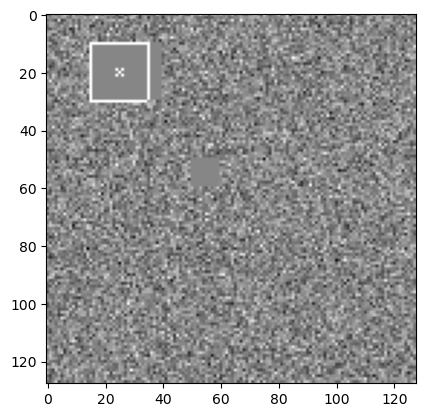

In [99]:
FindEmptySquareAreaPosition(a)

# debrics

In [ ]:
#  threshold for the difference between max and min values in the image. If this is exceeded, the region is considered to contain excessive roughness.
start_x = 0
start_y = 0
tip_x = 0
tip_y = 0
debris_thres = 6
DebresCounter = 0
noDebris = False
image_forward = info['img_info']['img_forward']
radius = 10
check_similarity=None

while not noDebris:
      noDebris =  ((np.max(image_forward) - np.min(image_forward)) < debris_thres)      
      if not noDebris:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        image=env.set_newtip_pos(tip_x, tip_y)
        image_forward, image_backward =image[0], image[1]
        radius=radius*2
        env.max_radius=300
        upper_limit_move=upper_limit_move+20000
        check_similarity.append([tip_x, tip_y])
        

# Lost probe_molecule contact and crashed

In [ ]:
# Crash dectected
crash_thres = 1e-25 
noCrash = False
approach_z = 4
while not noCrash:
    noCrash = (np.max(img_forward)-np.min(img_forward) )< crash_thres and (np.mean(img_forward)>0)
    
    if not noCrash:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        tip_z = env.createc_controller.set_Z_approach(approach_z)
        image=env.set_newtip_pos(tip_x, tip_y)
        image_forward, image_backward =image[0], image[1]
        radius=radius*2
        env.max_radius=300
        upper_limit_move=upper_limit_move+20000
        check_similarity.append([tip_x, tip_y])
        


In [31]:
env.createc_controller.set_Z_approach(4)

In [16]:
env.createc_controller.scan_image()

The scan will take 12.5 seconds
offset_test0000 [ 23.99753723 -23.99753723]
offset_test1111 [ 23.99753723 -23.99753723]
offset_test2222 [ 23.99753723 -23.99753723]


(array([[-2.01714039, -2.01696873, -2.01708841, ..., -2.02151728,
         -2.02146792, -2.02165771],
        [-2.02180839, -2.02207851, -2.02216959, ..., -2.02135611,
         -2.02143407, -2.02120018],
        [-2.0213275 , -2.02120543, -2.02127552, ..., -2.02428007,
         -2.02426982, -2.02433729],
        ...,
        [-2.02020478, -2.02010083, -2.02011633, ..., -2.02194095,
         -2.0220058 , -2.02209949],
        [-2.02213073, -2.02222681, -2.02220082, ..., -2.02358365,
         -2.02343535, -2.02330303],
        [-2.02324319, -2.02307653, -2.02307415, ..., -2.02321959,
         -2.02339125, -2.0235889 ]]),
 array([[-2.02011895, -2.02010083, -2.02044892, ..., -2.01993179,
         -2.02000189, -2.01992655],
        [-2.02000189, -2.02010846, -2.02038145, ..., -2.02390313,
         -2.02391624, -2.02399158],
        [-2.02402282, -2.02391624, -2.02373695, ..., -2.02405667,
         -2.02395511, -2.02376795],
        ...,
        [-2.02273369, -2.02253866, -2.02229953, ..., -

In [33]:
env.createc_controller.stm.quicksave()

# tip condition section

In [5]:
center_x=0
center_y=0
approach_area_length=800
def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length


    
    

In [29]:
env.createc_controller.im_size_nm=5

In [30]:
env.createc_controller.scan_image()

The scan will take 12.5 seconds
offset_test0000 [39.9988076 39.9988076]
offset_test1111 [39.9988076 39.9988076]
offset_test2222 [39.9988076 39.9988076]


(array([[-2.01714039, -2.01696873, -2.01708841, ..., -2.02151728,
         -2.02146792, -2.02165771],
        [-2.02180839, -2.02207851, -2.02216959, ..., -2.02135611,
         -2.02143407, -2.02120018],
        [-2.0213275 , -2.02120543, -2.02127552, ..., -2.02428007,
         -2.02426982, -2.02433729],
        ...,
        [-2.02020478, -2.02010083, -2.02011633, ..., -2.02194095,
         -2.0220058 , -2.02209949],
        [-2.02213073, -2.02222681, -2.02220082, ..., -2.02358365,
         -2.02343535, -2.02330303],
        [-2.02324319, -2.02307653, -2.02307415, ..., -2.02321959,
         -2.02339125, -2.0235889 ]]),
 array([[-2.02011895, -2.02010083, -2.02044892, ..., -2.01993179,
         -2.02000189, -2.01992655],
        [-2.02000189, -2.02010846, -2.02038145, ..., -2.02390313,
         -2.02391624, -2.02399158],
        [-2.02402282, -2.02391624, -2.02373695, ..., -2.02405667,
         -2.02395511, -2.02376795],
        ...,
        [-2.02273369, -2.02253866, -2.02229953, ..., -

In [28]:
env.createc_controller.scan_image()

The scan will take 12.5 seconds
offset_test0000 [39.9988076 39.9988076]
offset_test1111 [39.9988076 39.9988076]
offset_test2222 [39.9988076 39.9988076]


(array([[-2.01714039, -2.01696873, -2.01708841, ..., -2.02151728,
         -2.02146792, -2.02165771],
        [-2.02180839, -2.02207851, -2.02216959, ..., -2.02135611,
         -2.02143407, -2.02120018],
        [-2.0213275 , -2.02120543, -2.02127552, ..., -2.02428007,
         -2.02426982, -2.02433729],
        ...,
        [-2.02020478, -2.02010083, -2.02011633, ..., -2.02194095,
         -2.0220058 , -2.02209949],
        [-2.02213073, -2.02222681, -2.02220082, ..., -2.02358365,
         -2.02343535, -2.02330303],
        [-2.02324319, -2.02307653, -2.02307415, ..., -2.02321959,
         -2.02339125, -2.0235889 ]]),
 array([[-2.02011895, -2.02010083, -2.02044892, ..., -2.01993179,
         -2.02000189, -2.01992655],
        [-2.02000189, -2.02010846, -2.02038145, ..., -2.02390313,
         -2.02391624, -2.02399158],
        [-2.02402282, -2.02391624, -2.02373695, ..., -2.02405667,
         -2.02395511, -2.02376795],
        ...,
        [-2.02273369, -2.02253866, -2.02229953, ..., -

In [18]:
env.createc_controller.get_len_nm()

4.96083984375

In [33]:
env.createc_controller.tip_form(0.02, ref_x+i*cellsize, ref_y+j*cellsize)

In [34]:
env.createc_controller.scan_image()

The scan will take 12.5 seconds
offset_test0000 [40  0]
offset_test1111 [40  0]


KeyboardInterrupt: 

In [19]:
env.createc_controller.stm.getparam('Length x[A]')

'49.6099'

In [20]:
env.createc_controller.stm.getparam('Length y[A]')

'49.6099'

In [42]:
env.createc_controller.get_len_nm()

1.76572265625

In [43]:
env.createc_controller.im_size_nm

2

In [37]:
env.createc_controller.stm.setparam('Length y[A]', 58)

In [39]:
env.createc_controller.stm.setparam('Length x[A]', 58)

5
The scan will take 12.5 seconds
offset_test0000 [40  0]
offset_test1111 [40  0]


KeyboardInterrupt: 

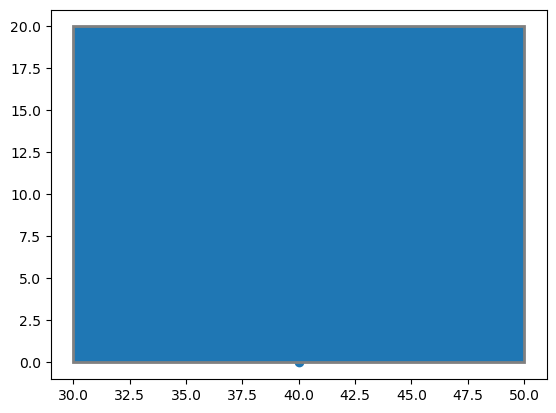

In [32]:
env.default_max_radius_cellsize(cellsize=20, max_radius=200)
env.computeLocationIDs()
points=env.computeLocationIDs()
all_x=np.array([i[0] for i in points])
all_y=np.array([i[1] for i in points])
ref_x=0
ref_y=0
cellsize=20
start_point=0
approach_z=0
for point in range(start_point, len(points)):
    i=points[point][0]
    j=points[point][1]
    plt.scatter(ref_x+i*cellsize,ref_y+j*cellsize)
    plt.gca().add_patch(patches.Rectangle((ref_x+i*cellsize-10,  ref_y+j*cellsize), 20, 20, fill=True, edgecolor='grey', lw=2))
#     env.tip_form(-1.2, 0.02, ref_x+i*cellsize, ref_y+j*cellsize)
    env.createc_controller.ramp_bias_mV(-1.2)
    env.createc_controller.tip_form(0.02, ref_x+i*cellsize, ref_y+j*cellsize)
    print(env.createc_controller.im_size_nm)
    
    tip_z = env.createc_controller.set_Z_approach(approach_z)
    
    env.set_newtip_pos(ref_x+i*cellsize, ref_y+j*cellsize)
#     env.createc_controller.scan_image()
#     env.createc_controller.stm.quicksave()
    start_point=point
    
plt.plot(ref_x+all_x*cellsize,ref_y+all_y*cellsize)


# Condition probe

In [ ]:
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)

env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)

env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [-0.80, 0.02],
                      'soft dip 2': [-1.2, 0.02],
                      'soft dip 3': [-1.8, 0.02],
                      'medium soft': [-2.5, 0.02],
                      'strong dip': [-5.0, 0.02]
                      }


In [ ]:
def tip_form(self, dip_z_nm: float, voltage: float, x_nm: float, y_nm: float) -> None:
    """Perform tip forming
    Parameters
    ----------
    dip_z_nm : float
        Z approach value in A
    voltage : float
        Voltage value in V
    x_nm, y_nm : float
        STM coordinates (nm)
    """
    offset_nm = self.get_offset_nm()
    len_nm = self.get_len_nm()
    self.stm.setparam('BiasVolt.[mV]',Voltage)
    self.ramp_bias_mV(mvoltage)
    preamp_grain = 10**float(self.stm.getparam("Latmangain"))
    self.stm.setparam("LatmanVolt",  mvoltage) #(mV)
#     self.stm.setparam("Latmanlgi", pcurrent*1e-9*preamp_grain) #(pA)
    
    self.set_Z_approach(A)
    args = x_nm, y_nm, None, None, offset_nm, len_nm
    x_pixel, y_pixel, _, _ = self.nm_to_pixel(*args)
    self.stm.btn_tipform(x_pixel, y_pixel)
    self.stm.waitms(50)

In [ ]:
self.ramp_bias_mV(self.scan_mV)
DAC_unit = 2**19
self.stm.setparam('Num.X',self.pixel)
GainX = float(self.stm.getparam("GainX"))
Delta_X = self.get_Delta_X(self.im_size_nm)
self.stm.setparam('Delta X [Dac]',Delta_X)
time.sleep(0.1)
scan_time = self.get_scan_time()
print('The scan will take {0:.1f} seconds'.format(scan_time))
if scan_time > 600:
    approve = input('Scan will take {} minutes, \
        type yes to continue and no to interrupt'.format(scan_time/60))
    if approve == 'no':
        return None, (None, None)
Xpiezoconst = float(self.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(self.stm.getparam("Ypiezoconst"))
xV = GainX*self.offset_nm[0]/Xpiezoconst
yV = GainX*self.offset_nm[1]/Ypiezoconst

In [ ]:
env.createc_controller.stm.getparam("GainX")
env.createc_controller.stm.getparam("Xpiezoconst")

In [ ]:
env.createc_controller.stm.setxyoffvolt(xV, yV)

In [ ]:
env.createc_controller.stm.getparam("Ypiezoconst")

In [ ]:
env.createc_controller.offset_nm=np.array([-15, 33])

In [ ]:
env.createc_controller.im_size_nm

In [ ]:
env.createc_controller.scan_image()

In [ ]:
env.createc_controller.get_offset_nm()

In [ ]:
state, info = env.reset(update_conv_net=False)

In [12]:
num_no_done = 0
episode_start=0
max_episode = 10
num_episodes=50
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    print('offffset0000',env.offset_nm)
    state, info = env.reset(update_conv_net=False)
    print(state, info)
    
 # detect atoms   

#  no debris

# crash or no probe-atom contact
    
    
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
               env.template_nm, env.template_wh)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    print('offffset1111',env.offset_nm)
    


    for step in range(max_steps):
        action = agent.select_action(state)
        old_atom_nm = env.atom_absolute_nm
        print('offffset2222',env.offset_nm)
        next_state, reward, done, info = env.step(action)
        print('offffset3333',env.offset_nm)
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        print(info)
        show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                    env.atom_absolute_nm, env.atom_start_absolute_nm, 
                    env.destination_absolute_nm, action[4]*env.max_mvolt, 
                    action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                    env.template_nm, env.template_wh)
        print('step:', step,'reward', reward, 'precision:', env.dist_destination)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:                
            state=next_state
            
    # if manipulation fails N times, adjust tip conditioning
    
    


        

    if (len(memory)>batch_size):
        episode_K = int(episode_steps)
        for k in range(episode_K):
            c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
            agent.update_parameters(memory, batch_size, c_k)

Episode: 0
offffset0000 [39.99775658 39.99775658]
The scan will take 12.5 seconds
offset_test0000 [39.99775658 39.99775658]
offset_test1111 [39.99775658 39.99775658]
offset_test2222 [39.99775658 39.99775658]
[[ 4.57409828e-03  4.75422011e-03  4.64299444e-03 ...  1.25476703e-03
   1.31258013e-03  1.13125940e-03]
 [-9.43183073e-05 -3.55986101e-04 -4.38601542e-04 ...  1.41551877e-03
   1.34601635e-03  1.58836543e-03]
 [ 3.86152743e-04  5.16683512e-04  4.55048906e-04 ... -1.50886591e-03
  -1.49015346e-03 -1.54916546e-03]
 ...
 [ 1.45730134e-03  1.56971230e-03  1.56267555e-03 ...  7.78694278e-04
   7.22304880e-04  6.37066835e-04]
 [-4.69063163e-04 -5.56685394e-04 -5.22237313e-04 ... -8.64428956e-04
  -7.07672144e-04 -5.66889376e-04]
 [-1.58194348e-03 -1.40682843e-03 -1.39598379e-03 ... -5.00783009e-04
  -6.63983930e-04 -8.53172476e-04]] 0.003634965699172096
[[ 1.62357570e-03  1.64786345e-03  1.30594026e-03 ...  2.58172629e-03
   2.51779917e-03  2.59930737e-03]
 [ 1.74509150e-03  1.64468633e

C:\Users\wun2\github\Atom_manipulation_with_RL_0523\AMRL\Environment\get_atom_coordinate.py:382: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  r = morphology.binary_dilation(maxima, selem=diamond)


The scan will take 12.5 seconds
offset_test0000 [39.99775658 39.99775658]
offset_test1111 [39.99775658 39.99775658]


com_error: (-2147023174, 'The RPC server is unavailable.', None, None)

In [ ]:
env.createc_controller.stm.scanstop()

In [ ]:
env.createc_controller.get_offset_nm()

In [ ]:
env.createc_controller.set_xy_nm(np.array([-50, 90]))

In [ ]:
createc_controller.set_xy_nm(np.array([-50, 90]))

In [ ]:
env.createc_controller.stm.setparam('OffsetX', '23000')
env.createc_controller.stm.setparam('OffsetY', '-45000')

In [ ]:
num_no_done = 0
max_episode = 10
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    state, info = env.reset(update_conv_net=False)
    
 # detect atoms   

#  no debris

# crash or no probe-atom contact
    
    
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
               env.template_nm, env.template_wh)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    


    for step in range(max_steps):
        action = agent.select_action(state)
        old_atom_nm = env.atom_absolute_nm
        next_state, reward, done, info = env.step(action)
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        print(info)
        show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                    env.atom_absolute_nm, env.atom_start_absolute_nm, 
                    env.destination_absolute_nm, action[4]*env.max_mvolt, 
                    action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                    env.template_nm, env.template_wh)
        print('step:', step,'reward', reward, 'precision:', env.dist_destination)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:                
            state=next_state
            
    # if manipulation fails N times, adjust tip conditioning

    if not done:
        num_no_done+= 1
        if num_no_done > max_episode:
            ID= compositionID(tip_x, tip_y)
            forbiden_area =  markForbiddenArea(actID=0, multiplier=(np.sqrt(float(self.noDebresCounter))*0.5) )
            tip_x_new, tip_y_new = New_tippos(tip_x, tip_y, forbiden:area) # 
            tip_z = Createc_Controller.set_z() # 
            tip_x_new, tip_y_new = New_tippos(tip_x, tip_y, forbiden:area) 
            createc_controller.set(dip, bias voltage)  # change
    else:
        num_no_done = 0
        

    if (len(memory)>batch_size):
        episode_K = int(episode_steps)
        for k in range(episode_K):
            c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
            agent.update_parameters(memory, batch_size, c_k)

### Define the training function

In [11]:
env.dist_destination=0.3934795995776328

### Train the RL agent

In [ ]:
import numpy as np

In [ ]:
data=np.load('training_data_and_model_parameters/training_data/00500.npy',allow_pickle=True).item()

In [ ]:
data['episode_start_info'].keys()

In [ ]:
data['episode_start_info']['info']

In [ ]:
data['episode_end_info']['atom_absolute_nm']

In [ ]:
data['episode_end_info']['atom_relative_nm']

In [ ]:
data['episode_end_info'].keys()

In [ ]:
data['transitions'].keys()

In [ ]:
data['transitions']['reward']

In [ ]:
data['transitions']['done']

In [ ]:
data['transitions']['info'][0].keys()

In [ ]:
data['transitions']['info'][2].keys()

In [ ]:
len(data['transitions']['info'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(9,9))
for i in range(5):
     plt.subplot(5,2,i*2+1)
     plt.imshow(data['transitions']['info'][i]['img_info']['img_forward'])
     plt.subplot(5,2,i*2+2)
     plt.imshow(data['transitions']['info'][i]['img_info']['img_backward'])

In [ ]:
data['transitions']['state']

In [ ]:
data['transitions']['action']

In [ ]:
data['transitions']['next_state']

In [ ]:
data['episode_start_info']

In [ ]:
plt.imshow(data['episode_end_info']['img_forward'])

In [ ]:
plt.imshow(data['episode_end_info']['img_backward'])

In [ ]:
plt.imshow(data['episode_start_info']['img_forward'])

In [ ]:
plt.imshow(data['episode_start_info']['img_backward'])

In [ ]:
sac_train(episode_start = 2887,num_episodes = 1000)